In [37]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

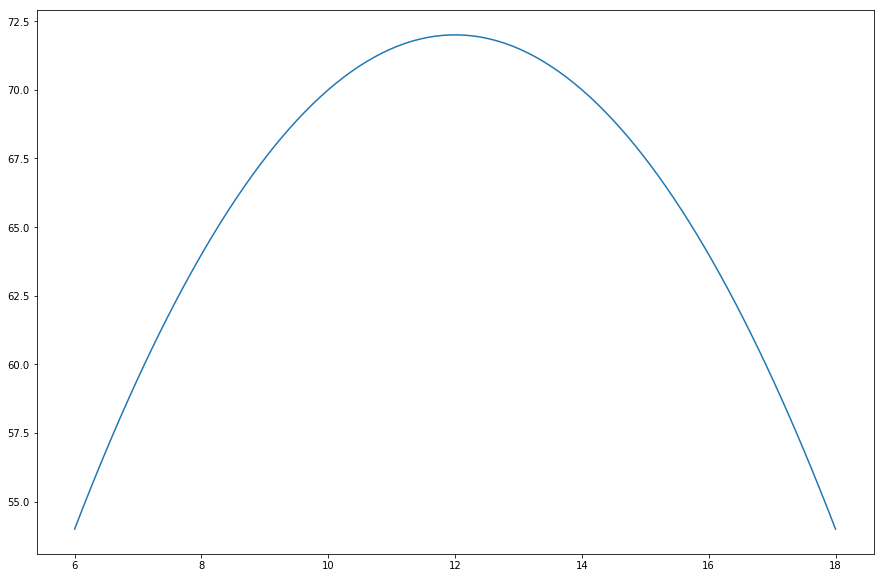

x tensor([12.0000], grad_fn=<AddBackward>)
y tensor([6.0000], requires_grad=True)
area tensor([72.], grad_fn=<ThMulBackward>)
perimeter tensor([24.], grad_fn=<ThAddBackward>)
x tensor([12.0015], requires_grad=True)
y tensor([6.0007], requires_grad=True)
area tensor([72.0179], grad_fn=<ThMulBackward>)
perimeter tensor([24.0030], grad_fn=<ThAddBackward>)


In [49]:
"""
A farmer has a fence of size 24 and must fence a terrain alongside a line that represents a river:

                   x
        +---------------------+
        |                     |
     y  |       Terrain       |
        |                     |
****************************************
                 RIVER

What is the maximum amount of terrain he can protect?

Formulate the equation:
* maximize x * y
* given perimeter = 2 * y + x = 24
"""

"""
Solve it using simple calculus

y = 12 - x/2
=> maximize x * (12 - x/2)
=> maximize - x ** 2 / 2 + 12 * x

Take the derivate and search for point = 0
=> 12 - x = 0 => x = 12

Check that it is a maximum (via second derivative):
=> -1 < 0 so it is a maximum

=> x = 12 and y = 6
=> area = 73

Trace the plot:
"""

fig, ax = plt.subplots(figsize=(15, 10))
xs = np.linspace(6, 18, 100)
ax.plot(xs, - xs ** 2 / 2 + 12 * xs)
plt.show()


"""
Solving it using Lagrange multipliers

grad (x * y) = a * grad (2 * y + x)

=> y = a (partial by x)
   x = 2 a (partial by y) = 2 * y
   2 * y + x = 24

=> 4 * y = 24 => y = 6 and x = 12
"""


"""
Solve it using overkill: Pytorch
(formulating things in terms of variable replacement)
"""

y_val = torch.tensor([1.], requires_grad=True)
y = nn.parameter.Parameter(y_val)

optimizer = optim.Adam([y], lr=1e-2)
for _ in range(5000):
    x = 24 - 2 * y
    neg_area = -1 * x * y
    optimizer.zero_grad()
    neg_area.backward()
    optimizer.step()

print("x", x)
print("y", y_val)
print("area", x * y)
print("perimeter", x + 2 * y)


"""
Solve it using overkill: Pytorch
(formulating things in terms of constraints)
"""

x_val = torch.tensor([22.], requires_grad=True)
y_val = torch.tensor([1.], requires_grad=True)
x = nn.parameter.Parameter(x_val)
y = nn.parameter.Parameter(y_val)

def perimeter_diff_loss(perimeter):
    # The higher the loss, the more we respect the constraint
    return 1000 * (perimeter - 24) ** 2

optimizer = optim.Adam([x, y], lr=1e-2)
for _ in range(5000):
    area = x * y
    perimeter = x + 2 * y
    q = - area + perimeter_diff_loss(perimeter)
    optimizer.zero_grad()
    q.backward()
    optimizer.step()

print("x", x_val)
print("y", y_val)
print("area", x * y)
print("perimeter", x + 2 * y)